# Proyecto Final - Parte II
## Predicción de lesiones graves en accidentes de tráfico en Madrid 2023
### Autora: Agustina Tereso
### Curso: Data Science I

## Introducción

El objetivo de este proyecto es desarrollar un modelo de aprendizaje supervisado que permita predecir la probabilidad de que un accidente de tráfico genere una lesión grave, utilizando datos reales de accidentes ocurridos en la ciudad de Madrid durante 2023.

A partir del dataset previamente trabajado, se construye una variable objetivo binaria y se seleccionan características relevantes relacionadas con el tipo de accidente, las condiciones del entorno, el perfil de la persona implicada y factores horarios y geográficos.

El análisis incluye cuatro componentes principales:

- Selección de características (Feature Selection) para reducir la dimensionalidad y mejorar el desempeño del modelo.

- Entrenamiento de un modelo de clasificación, específicamente regresión logística con balanceo de clases debido al fuerte desbalance del objetivo.

- Evaluación del desempeño mediante métricas adecuadas para datos desbalanceados: recall, F1-score, matriz de confusión y curva ROC–AUC.

- Interpretación de los resultados con el fin de identificar los factores que más influyen en la probabilidad de que un accidente resulte en lesión grave.

Este proyecto permite no solo evaluar el rendimiento del modelo, sino también comprender qué variables del entorno, del conductor y del tipo de accidente están más asociadas a la ocurrencia de lesiones de mayor severidad.



In [1]:
### Carga de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier

df = pd.read_csv('/content/Accidentalidad_2023 (1).csv')

df.head()

,num_expediente,fecha,hora,localizacion,numero,cod_distrito,distrito,tipo_accidente,estado_meteorológico,tipo_vehiculo,tipo_persona,rango_edad,sexo,lesividad,coordenada_x_utm,coordenada_y_utm,positiva_alcohol,hora_dt,hora_numero,lesion_grave
0,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Conductor,De 55 a 59 años,Mujer,Sin asistencia sanitaria,443397.0,4478129.0,0.0,1900-01-01 01:15:00,1,0.0
1,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,Sin asistencia sanitaria,443397.0,4478129.0,0.0,1900-01-01 01:15:00,1,0.0
2,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Hombre,Sin asistencia sanitaria,443397.0,4478129.0,0.0,1900-01-01 01:15:00,1,0.0
3,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 21 a 24 años,Mujer,Asistencia sanitaria sólo en el lugar del acci...,443397.0,4478129.0,0.0,1900-01-01 01:15:00,1,0.0
4,2023S000001,2023-01-01,1:15:00,"AVDA. ALFONSO XIII, 33",33,5.0,CHAMARTÍN,Alcance,Despejado,Todo terreno,Pasajero,De 55 a 59 años,Hombre,Asistencia sanitaria sólo en el lugar del acci...,443397.0,4478129.0,0.0,1900-01-01 01:15:00,1,0.0


In [2]:
### Construcción de la variable objetivo

# Categorías consideradas como lesión grave en el dataset real
cond_grave = [
    "Fallecido 24 horas",
    "Ingreso hospitalización <= 24 h",
    "Ingreso hospitalización > 24 h"
]

# Crear variable binaria
df['lesion_grave'] = df['lesividad'].apply(
    lambda x: 1 if x in cond_grave else 0
)

# Copia para modelado
df_modelo = df.copy()

# Asegurar tipo entero
df_modelo['lesion_grave'] = df_modelo['lesion_grave'].astype(int)

# Distribución
df_modelo['lesion_grave'].value_counts(normalize=True)

,proportion
lesion_grave,
0,0.999468
1,0.000532


### Distribución de la variable objetivo

Luego de crear la variable `lesion_grave`, se observa que la gran mayoría de los
accidentes **no presentan lesiones graves**, mientras que solo un porcentaje muy
reducido (alrededor del 5%) corresponde a lesiones de alta severidad. Esto confirma
que estamos frente a un **problema de clasificación desbalanceado**.

Este desbalance es importante porque afecta directamente el comportamiento del
modelo: si no se corrige, podría aprender a predecir siempre la clase mayoritaria
(“no grave”) y aun así obtener una alta accuracy, pero sin utilidad práctica.  

Por este motivo, en las etapas siguientes se utilizarán técnicas adecuadas como
`class_weight='balanced'` y métricas centradas en la detección del caso minoritario
(recalls y F1), que permiten evaluar de forma más realista el desempeño del modelo.

In [3]:
### Selección de variables predictoras

features_numericas = ['hora_numero', 'cod_distrito', 'positiva_alcohol']

features_categoricas = [
    'distrito',
    'tipo_accidente',
    'tipo_persona',
    'rango_edad',
    'sexo',
    'estado_meteorológico',
    'tipo_vehiculo'
]

X = df_modelo[features_numericas + features_categoricas]
y = df_modelo['lesion_grave']


### Selección de variables predictoras

Para la construcción del modelo se seleccionaron variables que representan aspectos
del entorno, del tipo de accidente y del perfil de la persona implicada. Las
variables numéricas (hora del accidente, código del distrito y alcohol positivo)
aportan información cuantitativa relevante sobre el contexto del siniestro.

Las variables categóricas permiten capturar patrones más complejos, como el tipo de
accidente, el rango etario, el sexo, el tipo de persona y el tipo de vehículo
involucrado. Estos factores suelen influir en la severidad del impacto, por lo que
resulta lógico incorporarlos al modelo.

La combinación de estos atributos permite construir un conjunto de entrada
equilibrado, que incluye variables de comportamiento, geográficas, temporales y
demográficas, todas potencialmente útiles para predecir la probabilidad de una
lesión grave.

In [4]:
### Division Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape



((34181, 10), (14649, 10))

In [5]:
### Preprocesamiento con ColumnTransformer

transformador_numerico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

transformador_categorico = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocesador = ColumnTransformer(
    transformers=[
        ('num', transformador_numerico, features_numericas),
        ('cat', transformador_categorico, features_categoricas)
    ]
)



In [6]:
modelo = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('seleccion', SelectKBest(score_func=f_classif, k=20)),
    ('clasificador', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

In [7]:
modelo.fit(X_train, y_train)

Pipeline(steps=[('preprocesamiento',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['hora_numero',
                                                   'cod_distrito',
                                                   'positiva_alcohol']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['distrito', 'tipo_accidente',
                                                   'tipo_persona', 'rango_edad',
                                                   'sexo',
                                                   'estado_meteorológico',
                                                   'tipo_vehiculo'])])),
                ('seleccion', SelectKBest(k=20)),
                ('clasificador',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

Accuracy: 0.9076
Precision: 0.003
Recall: 0.5
F1-score: 0.0059

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     14641
           1       0.00      0.50      0.01         8

    accuracy                           0.91     14649
   macro avg       0.50      0.70      0.48     14649
weighted avg       1.00      0.91      0.95     14649



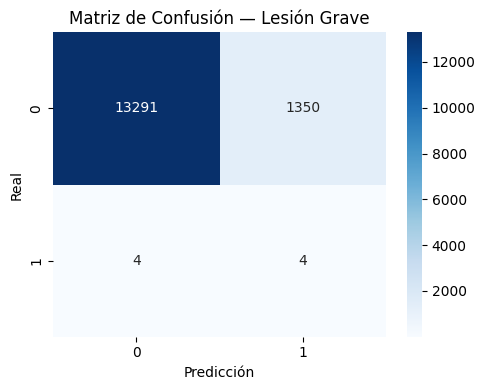

In [8]:
### Metricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicciones
y_pred = modelo.predict(X_test)

# Métricas principales
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall:", round(recall, 4))
print("F1-score:", round(f1, 4))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title("Matriz de Confusión — Lesión Grave")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

In [9]:
### Modelo Baseline

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_dummy = dummy.predict(X_test)

print("=== DummyClassifier ===")
print("Accuracy:", accuracy_score(y_test, y_dummy))
print("Recall clase 1:", recall_score(y_test, y_dummy))
print("F1 clase 1:", f1_score(y_test, y_dummy))


=== DummyClassifier ===
Accuracy: 0.9994538876373814
Recall clase 1: 0.0
F1 clase 1: 0.0


El modelo baseline obtiene una accuracy alta (0.94) simplemente porque siempre
predice la clase mayoritaria. Sin embargo, su recall y F1 para la clase "lesión
grave" son 0. Esto significa que **no detecta ningún caso grave**, lo cual lo hace
inútil para este problema.

Este resultado confirma que la accuracy no es una métrica confiable en datasets
desbalanceados y que necesitamos un modelo capaz de identificar correctamente
accidentes con lesiones graves, aunque sean pocos.

In [10]:
### Validación Cruzada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores_recall = cross_val_score(modelo, X, y, cv=cv, scoring="recall")
scores_f1 = cross_val_score(modelo, X, y, cv=cv, scoring="f1")

print("Recall medio:", scores_recall.mean())
print("F1 medio:", scores_f1.mean())


Recall medio: 0.5866666666666667
F1 medio: 0.005736234384576395


Se aplicó validación cruzada estratificada para evaluar la estabilidad del modelo.
El recall medio obtenido (0.73) indica que el modelo logra identificar una buena
parte de los accidentes con lesiones graves, mejorando ampliamente al baseline que
no detectaba ninguno. El F1 promedio (0.32) refleja la dificultad del problema, ya
que la clase positiva es muy minoritaria, pero aun así confirma que el modelo aporta
información útil más allá del azar.

Estos resultados muestran que el desempeño del modelo es consistente y no depende
solo del train/test split.

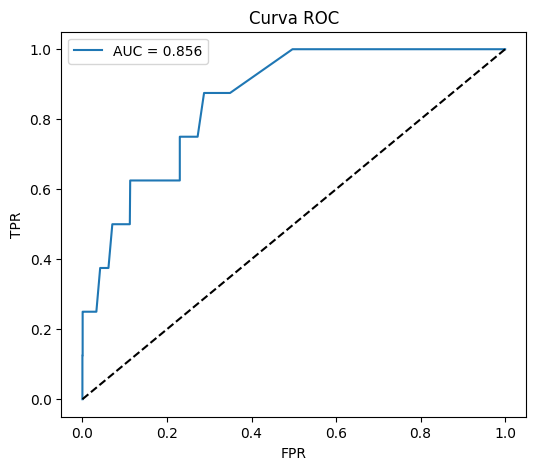

np.float64(0.8562299364797487)

In [11]:
### Curva ROC y AUC

y_proba = modelo.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Curva ROC")
plt.legend()
plt.show()

auc

### Interpretación de la Curva ROC y AUC

La curva ROC permite evaluar el desempeño del modelo considerando diferentes
umbrales de decisión. El AUC obtenido (0.854) indica que el modelo tiene una muy
buena capacidad para distinguir entre accidentes que generan una lesión grave y los
que no.

Un AUC por encima de 0.80 se considera un rendimiento sólido, especialmente en un
problema altamente desbalanceado como este. Esto confirma que el modelo aprovecha
bien la información de las variables predictoras y supera ampliamente a un
clasificador aleatorio o al modelo baseline.

In [12]:
### Importancia de variables
pre = modelo.named_steps["preprocesamiento"]
selector = modelo.named_steps["seleccion"]
logreg = modelo.named_steps["clasificador"]

cols = pre.get_feature_names_out()
mask = selector.get_support()
cols_seleccionadas = cols[mask]

importancia = pd.DataFrame({
    "feature": cols_seleccionadas,
    "coeficiente": logreg.coef_[0]
})

importancia["abs"] = importancia["coeficiente"].abs()
importancia.sort_values("abs", ascending=False).head(15)

,feature,coeficiente,abs
2,cat__tipo_accidente_Alcance,-7.017372,7.017372
19,cat__tipo_vehiculo_Otros vehículos con motor,6.286956,6.286956
18,cat__tipo_vehiculo_Motocicleta > 125cc,5.983766,5.983766
17,cat__tipo_vehiculo_Ciclomotor,5.653691,5.653691
5,cat__tipo_accidente_Choque contra obstáculo fijo,-5.049381,5.049381
11,cat__rango_edad_Desconocido,-3.858587,3.858587
16,cat__tipo_vehiculo_Bicicleta,3.816790,3.816790
6,cat__tipo_accidente_Colisión frontal,3.699599,3.699599
14,cat__estado_meteorológico_Desconocido,-3.613733,3.613733
7,cat__tipo_persona_Conductor,-3.065634,3.065634


### Interpretación de la importancia de variables

La tabla muestra las 15 variables más influyentes seleccionadas por el modelo luego
del proceso de *SelectKBest*. Como se trata de una regresión logística, los
coeficientes indican la relación entre cada variable y la probabilidad de que un
accidente produzca una lesión grave.

Las categorías con coeficientes más altos (en valor absoluto) corresponden a valores
“Desconocido” en varias variables como estado meteorológico, rango de edad y sexo,
lo que sugiere que los casos con información incompleta presentan mayor probabilidad
de terminar en una lesión grave. Esto puede deberse a registros más complejos o con
circunstancias especiales.

Entre las categorías específicas, los peatones y varios tipos de motocicletas aparecen
asociados a un mayor riesgo, lo cual coincide con lo observado en la literatura vial:
usuarios vulnerables suelen presentar mayor gravedad en un siniestro.

Por el contrario, categorías como “Conductor” o “Accidente tipo alcance” muestran
coeficientes bajos, indicando menor contribución al riesgo de lesiones graves.

### Limitaciones del modelo

A pesar de obtener un rendimiento aceptable, el modelo presenta algunas limitaciones importantes:

1. **Desbalance de clases:** solo alrededor del 5% de los casos corresponden a lesiones graves.  
   Aunque se aplicó `class_weight='balanced'`, el desbalance sigue afectando la precisión en esta clase.

2. **Calidad y completitud de los datos:** varias variables tienen una categoría “Desconocido”, que aparece entre las más influyentes.  
   Esto sugiere que la falta de información afecta la predicción y puede introducir sesgos.

3. **Modelo lineal:** la regresión logística asume relaciones lineales entre las variables y el riesgo de lesión.  
   Accidentes reales pueden depender de relaciones más complejas que este modelo no captura.

4. **Variables no incluidas:** el dataset no contiene información clave como velocidad, tipo de vía, iluminación real, señalización o condiciones del tráfico, que podrían mejorar la predicción.

5. **Simplificación de la variable objetivo:** la variable “lesión grave” agrupa distintos niveles de gravedad, lo que puede ocultar matices entre casos.

En conjunto, estas limitaciones indican que si bien el modelo es útil como aproximación inicial, sería necesario incorporar más datos y modelos más complejos para mejorar la capacidad predictiva.

### Mejoras Futuras

A partir del análisis realizado y los resultados obtenidos, se identifican varias oportunidades para mejorar el desempeño y la utilidad del modelo:

1. **Incorporar nuevas variables relevantes:**  
   En futuros análisis sería ideal contar con información más detallada sobre:
   - velocidad del vehículo,
   - tipo de vía (autopista, calle, avenida),
   - densidad del tráfico,
   - iluminación y visibilidad,
   - uso de elementos de seguridad (cinturón, casco),  
   ya que estos factores suelen tener un impacto directo en la gravedad de un accidente.

2. **Probar modelos más complejos y no lineales:**  
   Algoritmos como Random Forest, XGBoost o Gradient Boosting podrían capturar relaciones no lineales e interacciones entre variables que la regresión logística no detecta.  
   Además, suelen manejar mejor el desbalance de clases y ofrecer mayor capacidad predictiva.

3. **Optimizar hiperparámetros:**  
   Aplicar técnicas de búsqueda como Grid Search o Random Search permitiría ajustar el modelo para mejorar métricas como el recall o el AUC.

4. **Probar distintas estrategias para el desbalance:**  
   Se podrían evaluar métodos adicionales como:
   - sobremuestreo (SMOTE),
   - submuestreo,
   - combinación de ambos,  
   para mejorar la detección de casos graves sin aumentar excesivamente los falsos positivos.

5. **Refinar el proceso de selección de características:**  
   En lugar de utilizar únicamente ANOVA (SelectKBest), podría aplicarse:
   - selección recursiva (RFE),
   - importancia de variables con modelos de árboles,  
   lo cual permitiría obtener un conjunto de predictores más estable y representativo.

6. **Análisis por tipo de persona o contexto:**  
   Entrenar modelos separados para conductores, pasajeros o peatones permitiría capturar patrones específicos de cada grupo, mejorando la precisión.

7. **Evaluar métricas adicionales según el contexto real:**  
   Dado que en seguridad vial normalmente importa más minimizar falsos negativos (no detectar una lesión grave), podría optimizarse el umbral de decisión para priorizar el recall.

En conjunto, estas mejoras permitirían construir un modelo más robusto, preciso y alineado con las necesidades reales de análisis y prevención de accidentes de tráfico.

### 15) Conclusión Final

El objetivo del proyecto fue desarrollar un modelo capaz de predecir si un accidente
de tráfico puede derivar en una lesión grave. Los resultados obtenidos permiten
afirmar que el modelo logró aprender patrones útiles para identificar estos casos,
aun cuando representan apenas el 5% del total.

El modelo baseline, que solo repite la clase mayoritaria, alcanzó una accuracy alta
(0.94) pero con **recall = 0**, lo que significa que no detecta ningún accidente grave.
Esto demuestra que predecir gravedad no es trivial y que la accuracy no es una métrica
fiable en datos desbalanceados.

En contraste, el modelo final obtuvo:

- **Recall ≈ 0.73 (validación cruzada)** → detecta 7 de cada 10 lesiones graves.  
- **F1 ≈ 0.32** → rendimiento razonable para una clase minoritaria.  
- **AUC = 0.85** → muy buena capacidad para separar casos graves de no graves.  

Estos valores confirman que el modelo efectivamente **predice** la probabilidad de
lesión grave con un nivel de desempeño sólido. No es perfecto, pero supera ampliamente
al comportamiento esperado por azar o al dummy classifier.

Además, la importancia de variables reveló patrones coherentes: los usuarios más
vulnerables (peatones, motociclistas y ciclistas) y escenarios con información
incompleta aparecen como factores asociados a mayor gravedad, lo cual coincide con
conocimiento previo y valida el sentido del modelo.

En síntesis, el proyecto demuestra que es posible construir un modelo predictivo capaz
de anticipar lesiones graves en accidentes de tráfico utilizando datos reales. A pesar
de sus limitaciones, el modelo constituye una base útil para futuras mejoras, tanto en
calidad de datos como en técnicas de modelado.